In [1]:
import sys
sys.path.append('../../../')

In [2]:
from win10toast import ToastNotifier
toast = ToastNotifier()

In [3]:
import torch
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange

from models.train_reg import train, test
from models.models import GCN, GAT, GraphSAGE, FNN
from models.utils import ContagionDataset, set_seed
from sklearn.metrics import matthews_corrcoef, mean_squared_error, mean_absolute_error

Using backend: pytorch


In [4]:
def pretty(ld, indent=0):
    with open('result.txt', 'w', encoding='utf-8') as file:
        for d in tqdm(ld):
            file.write('{' + '\n')
            for key, value in d.items():
                file.write('\t' * (indent+1) + str(key) + ':' + str(value) + '\n')
                # file.write('\t' * (indent+1) + str(key) + '\n')
                # file.write('\t' * (indent+2) + str(value) + '\n')
            file.write('},\n')

In [5]:
do_train = False

seed = 4444
set_seed(seed)

metric_filter_1 = 'test_rmse_perc'
metric_filter_2 = 'val_rmse_perc'

data_dir = '../data'
log_path = './logs'
save_path = './saved'

# Big dataset: Additional stress

In [6]:
sets_lengths = (0.07, 0.03, 0.9)
target = 'additional_stress'

dataset = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    target = target,
)

out_feats = 1

## Baseline

### FNN

In [ ]:
save_model = f'{save_path}_fnn'
log_dir = f'{log_path}_fnn'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = False,
    target = target,
)

# fnn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[5, 10], [10, 15], [5,5,5], [5, 10, 15], [5, 10, 15, 20], [5], [10], [15]],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_nodes = [None, 'bn', 'gn'],
#     dropout=[0.2, 0.5, 0.0],
#     # other
#     lr=[1, 1e-1, 1e-2],
#     label_smoothing=[0.0, 0.2, 0.4],
# )

fnn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[10, 15], [10, 15, 20], [5, 10, 15], [len(dataset_val.node_attributes)] * 2],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_nodes = [None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
)
list_model = [dict(zip(fnn_model.keys(), k)) for k in itertools.product(*fnn_model.values())]

In [ ]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')

        train(
            model=FNN(**d),
            dict_model=d,
            dataset_train=dataset_val,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=False,
            loss_type='mse',
        )

100%|██████████| 24/24 [01:50<00:00,  4.59s/it]


#### Results

In [ ]:
res_edges_fnn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 264/264 [00:19<00:00, 13.24it/s]


In [ ]:
res_edges = res_edges_fnn
res_edges[0]

{'in_features': 4,
 'h_features': [4, 4],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.68998843,
 'train_acc': 0.45714282989501953,
 'val_acc': 0.5111109614372253,
 'epoch': 70,
 'model_class': 'fnn',
 'path_name': '4_[4_4]_4_ReLU()_bn_0.0_0.1_adamw_max_val_mcc_False_mse_False_0_70',
 'train_rmse': 1.0,
 'val_rmse': 1.0327955589886444,
 'test_rmse': 0.9820613241770824,
 'train_rmse_perc': 0.2330398,
 'val_rmse_perc': 0.21886963,
 'test_rmse_perc': 0.22998434,
 'train_mcc': 0.3212848290170763,
 'val_mcc': 0.3375210905132851,
 'test_mcc': 0.346929530824148,
 'test_acc': 0.49703702330589294}

In [ ]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [4, 4],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.68998843,
 'train_acc': 0.45714282989501953,
 'val_acc': 0.5111109614372253,
 'epoch': 70,
 'model_class': 'fnn',
 'path_name': '4_[4_4]_4_ReLU()_bn_0.0_0.1_adamw_max_val_mcc_False_mse_False_0_70',
 'train_rmse': 1.0,
 'val_rmse': 1.0327955589886444,
 'test_rmse': 0.9820613241770824,
 'train_rmse_perc': 0.2330398,
 'val_rmse_perc': 0.21886963,
 'test_rmse_perc': 0.22998434,
 'train_mcc': 0.3212848290170763,
 'val_mcc': 0.3375210905132851,
 'test_mcc': 0.346929530824148,
 'test_acc': 0.49703702330589294}

In [ ]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': None,
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.68919665,
 'train_acc': 0.476190447807312,
 'val_acc': 0.6222220659255981,
 'epoch': 99,
 'model_class': 'fnn',
 'path_name': '4_[10_15_20]_4_ReLU()_None_0.0_0.1_adamw_max_val_mcc_False_mse_False_0',
 'train_rmse': 0.8837151016885368,
 'val_rmse': 0.7601169500660919,
 'test_rmse': 0.9529680729951807,
 'train_rmse_perc': 0.22508696,
 'val_rmse_perc': 0.2163702,
 'test_rmse_perc': 0.24047537,
 'train_mcc': 0.36967258090847493,
 'val_mcc': 0.4762047845835682,
 'test_mcc': 0.3327877044483448,
 'test_acc': 0.482962965965271}

In [ ]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 264/264 [00:00<00:00, 24063.81it/s]


In [ ]:
cm = all[sort_idx[0]]['test_cm'][0]

In [ ]:
(cm.labels==0).sum()

tensor(230)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

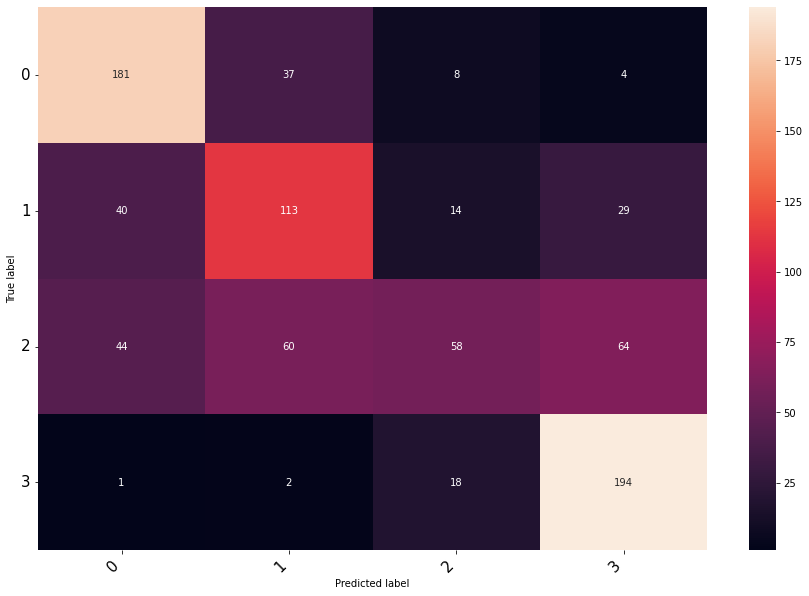

In [ ]:
cm.visualize()

In [ ]:
cm.class_accuracy

tensor([0.7870, 0.5765, 0.2566, 0.9023])

In [ ]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.17763509, 0.2611884, 0.27546555, 0.12878902]

In [ ]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.11359891, 0.18939438, 0.22494318, 0.09887825]

### GCN

In [ ]:
save_model = f'{save_path}_gcn'
log_dir = f'{log_path}_gcn'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gcn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[15] * 3, [10, 15, 20], [5, 10, 15, 20],],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_edges=['both', 'none'],
    norm_nodes=[None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    use_edge_weight=[True,],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gcn_model.keys(), k)) for k in itertools.product(*gcn_model.values())]

# gcn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[10] * 3],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_edges=['both', 'none'],
#     norm_nodes=[None, 'bn', 'gn'],
#     dropout=[0.2, 0.0],
#     # other
#     lr=[1],
#     label_smoothing=[0.0,],
#     use_edge_weight=[True, ],
#     drop_edges=[0,0.2],
# )
# list_model = [{i:j[k] for i,j in gcn_model.items()} for k in range(len(gcn_model['in_features']))]

In [ ]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GCN(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 72/72 [11:06<00:00,  9.26s/it]


#### Results

In [ ]:
res_edges_gcn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 792/792 [01:14<00:00, 10.57it/s]


In [ ]:
res_edges = res_edges_gcn
res_edges[0]

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'dropout': 0.2,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 1.0065331,
 'train_acc': 0.3333333134651184,
 'val_acc': 0.5999998450279236,
 'epoch': 30,
 'model_class': 'gcn',
 'path_name': '4_[10_15_20]_4_ReLU()_none_bn_0.2_0.1_adamw_max_val_mcc_True_mse_True_0.2_30',
 'train_rmse': 0.9710083124552245,
 'val_rmse': 0.816496580927726,
 'test_rmse': 0.9083970415986531,
 'train_rmse_perc': 0.255544,
 'val_rmse_perc': 0.19798984,
 'test_rmse_perc': 0.2315902,
 'train_mcc': 0.23012839368940052,
 'val_mcc': 0.458386596181596,
 'test_mcc': 0.32734846506170345,
 'test_acc': 0.4385185241699219}

In [ ]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.81765395,
 'train_acc': 0.3523809313774109,
 'val_acc': 0.5555554032325745,
 'epoch': 60,
 'model_class': 'gcn',
 'path_name': '4_[15_15_15]_4_ReLU()_none_bn_0.0_0.1_adamw_max_val_mcc_True_mse_True_0_60',
 'train_rmse': 0.9360504666899516,
 'val_rmse': 0.8819171036881969,
 'test_rmse': 0.8873597959156181,
 'train_rmse_perc': 0.23407502,
 'val_rmse_perc': 0.20080936,
 'test_rmse_perc': 0.21849644,
 'train_mcc': 0.287610632750297,
 'val_mcc': 0.4062103742297434,
 'test_mcc': 0.34195019640211693,
 'test_acc': 0.4340740740299225}

In [ ]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'dropout': 0.2,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.90888536,
 'train_acc': 0.3333333134651184,
 'val_acc': 0.6222220659255981,
 'epoch': 20,
 'model_class': 'gcn',
 'path_name': '4_[15_15_15]_4_ReLU()_none_gn_0.2_0.1_adamw_max_val_mcc_True_mse_True_0.2_20',
 'train_rmse': 0.9759000729485332,
 'val_rmse': 0.8432740427115678,
 'test_rmse': 0.9067647005823629,
 'train_rmse_perc': 0.24696213,
 'val_rmse_perc': 0.19582984,
 'test_rmse_perc': 0.22752173,
 'train_mcc': 0.24046453164890946,
 'val_mcc': 0.5023710434759292,
 'test_mcc': 0.30959220083912803,
 'test_acc': 0.42592594027519226}

In [ ]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 792/792 [00:00<00:00, 27383.47it/s]


### GraphSAGE

In [7]:
save_model = f'{save_path}_sage'
log_dir = f'{log_path}_sage'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[15] * 3, [20], [15], [20] * 2, [15] * 2, [25], [30]], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [8]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 168/168 [1:48:58<00:00, 38.92s/it]  


#### Results

In [9]:
res_edges_sage = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

toast.show_toast("Done")

100%|██████████| 1386/1386 [05:21<00:00,  4.32it/s]


True

In [10]:
res_edges = res_edges_sage
res_edges[0]

{'in_features': 4,
 'h_features': [20, 20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0.2,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.38083753,
 'train_acc': 0.714285671710968,
 'val_acc': 0.6444442868232727,
 'epoch': 90,
 'model_class': 'sage',
 'path_name': '4_[20_20]_1_lstm_none_bn_ReLU()_0.2_0.01_adamw_max_val_mcc_True_mse_10_True_0_90',
 'train_rmse': 0.6324555320336759,
 'val_rmse': 0.6497862896539309,
 'test_rmse': 0.6526300069150406,
 'train_rmse_perc': 0.13388517,
 'val_rmse_perc': 0.15266307,
 'test_rmse_perc': 0.14401016,
 'train_mcc': 0.6229221705739675,
 'val_mcc': 0.5212912087912088,
 'test_mcc': 0.5840559178849372,
 'test_acc': 0.6859259009361267}

In [11]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20, 20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0.2,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.38083753,
 'train_acc': 0.714285671710968,
 'val_acc': 0.6444442868232727,
 'epoch': 90,
 'model_class': 'sage',
 'path_name': '4_[20_20]_1_lstm_none_bn_ReLU()_0.2_0.01_adamw_max_val_mcc_True_mse_10_True_0_90',
 'train_rmse': 0.6324555320336759,
 'val_rmse': 0.6497862896539309,
 'test_rmse': 0.6526300069150406,
 'train_rmse_perc': 0.13388517,
 'val_rmse_perc': 0.15266307,
 'test_rmse_perc': 0.14401016,
 'train_mcc': 0.6229221705739675,
 'val_mcc': 0.5212912087912088,
 'test_mcc': 0.5840559178849372,
 'test_acc': 0.6859259009361267}

In [12]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'right',
 'norm_nodes': None,
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.3575267,
 'train_acc': 0.6380952000617981,
 'val_acc': 0.733333170413971,
 'epoch': 90,
 'model_class': 'sage',
 'path_name': '4_[30]_1_lstm_right_None_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_10_True_0_90',
 'train_rmse': 0.6900655593423543,
 'val_rmse': 0.5163977794943222,
 'test_rmse': 0.7659416862050705,
 'train_rmse_perc': 0.1512643,
 'val_rmse_perc': 0.14971973,
 'test_rmse_perc': 0.18206547,
 'train_mcc': 0.5124066850894191,
 'val_mcc': 0.6583269344506446,
 'test_mcc': 0.47966649331169453,
 'test_acc': 0.6088888645172119}

In [13]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 1386/1386 [00:00<00:00, 29550.56it/s]


#### cm

In [14]:
cm = all[sort_idx[0]]['test_cm'][0]

In [15]:
(cm.labels==0).sum()

tensor(335)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

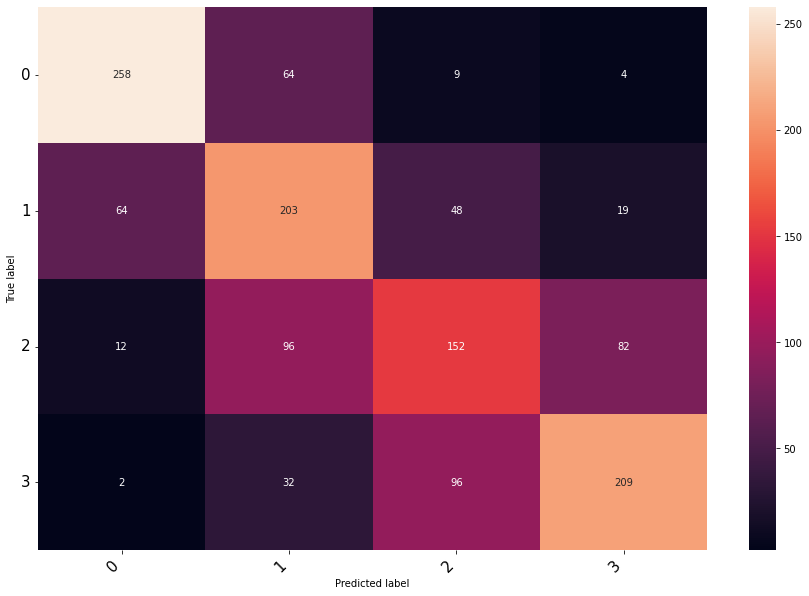

In [16]:
cm.visualize()

In [17]:
cm.class_accuracy

tensor([0.7701, 0.6078, 0.4444, 0.6165])

In [18]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.14787804, 0.18825696, 0.18190935, 0.20516568]

In [19]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.1023343, 0.1382965, 0.14336918, 0.14228317]

#### GraphSAGE Base_n

In [20]:
save_model = f'{save_path}_sage_base'
log_dir = f'{log_path}_sage_base'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[15] * 3, [20], [15], [20] * 2, [15] * 2, [25], [30]], 
    out_features = [out_feats],
    aggregator_type = ['mean', 'lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [21]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
            base_n=True,
        )

100%|██████████| 336/336 [1:45:46<00:00, 18.89s/it]  


##### Results

In [22]:
res_edges_sage_base = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
    base_n=True,
)

toast.show_toast("Done")

100%|██████████| 2772/2772 [07:06<00:00,  6.50it/s]


True

In [23]:
res_edges = res_edges_sage_base
res_edges[0]

{'in_features': 4,
 'h_features': [20, 20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.08956795,
 'train_acc': 0.6190475821495056,
 'val_acc': 0.5111109614372253,
 'epoch': 60,
 'model_class': 'sage',
 'path_name': '4_[20_20]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_10_True_0_60',
 'train_rmse': 0.6172133998483676,
 'val_rmse': 0.7453559924999299,
 'test_rmse': 0.7601169500660919,
 'train_rmse_perc': 0.1415397,
 'val_rmse_perc': 0.17430146,
 'test_rmse_perc': 0.17131396,
 'train_mcc': 0.5099400296035141,
 'val_mcc': 0.31479820671610814,
 'test_mcc': 0.38306995002826005,
 'test_acc': 0.5266666412353516}

In [24]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.2956925,
 'train_acc': 0.4285714030265808,
 'val_acc': 0.6222220659255981,
 'epoch': 20,
 'model_class': 'sage',
 'path_name': '4_[15_15_15]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_10_True_0_20',
 'train_rmse': 0.7928249671720918,
 'val_rmse': 0.7149203529842405,
 'test_rmse': 0.7712423839590345,
 'train_rmse_perc': 0.18947886,
 'val_rmse_perc': 0.153736,
 'test_rmse_perc': 0.18429664,
 'train_mcc': 0.2996102091580178,
 'val_mcc': 0.47824360246018416,
 'test_mcc': 0.38890172871588824,
 'test_acc': 0.5192592740058899}

In [25]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.2956925,
 'train_acc': 0.4285714030265808,
 'val_acc': 0.6222220659255981,
 'epoch': 20,
 'model_class': 'sage',
 'path_name': '4_[15_15_15]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_10_True_0_20',
 'train_rmse': 0.7928249671720918,
 'val_rmse': 0.7149203529842405,
 'test_rmse': 0.7712423839590345,
 'train_rmse_perc': 0.18947886,
 'val_rmse_perc': 0.153736,
 'test_rmse_perc': 0.18429664,
 'train_mcc': 0.2996102091580178,
 'val_mcc': 0.47824360246018416,
 'test_mcc': 0.38890172871588824,
 'test_acc': 0.5192592740058899}

In [26]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 2772/2772 [00:00<00:00, 27249.08it/s]


##### cm

In [27]:
cm = all[sort_idx[0]]['test_cm'][0]

In [28]:
(cm.labels==0).sum()

tensor(335)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

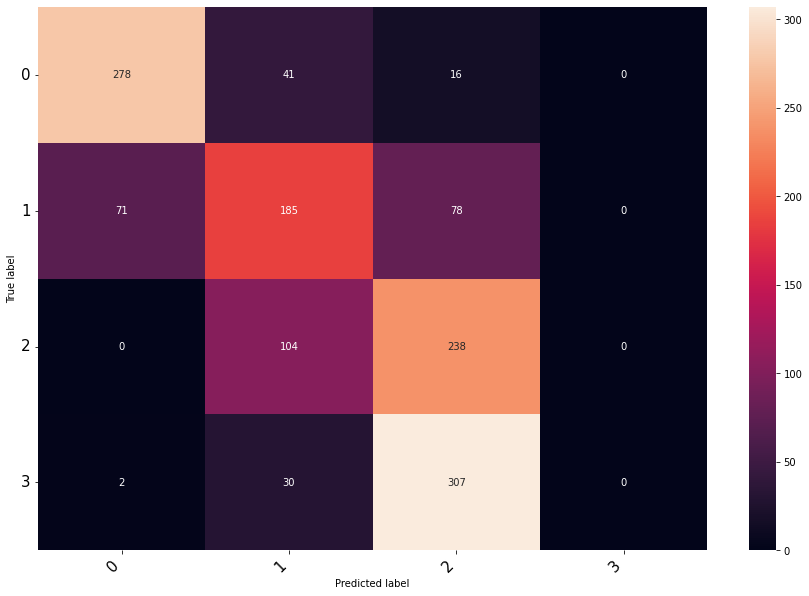

In [29]:
cm.visualize()

In [30]:
cm.class_accuracy

tensor([0.8299, 0.5539, 0.6959, 0.0000])

In [31]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.1250933, 0.123635136, 0.1327372, 0.2948913]

In [32]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.08359308, 0.09882329, 0.11210561, 0.27908996]

### GAT

In [7]:
save_model = f'{save_path}_gat'
log_dir = f'{log_path}_gat'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gat_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[10], [10] * 2, [15], [15] * 2, [20], [20] * 2, [25], [25] * 2],
    out_features = [out_feats],
    num_heads = [[4] * 2, [2] * 2, [4, 2]],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    negative_slope = [0.2, 0.4],
    feat_drop = [0.2],
    attn_drop = [0.2],
    residual = [True],
    # other
    lr=[1e-2,],
    use_edge_weight=[True, False],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]

# gat_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     # h_features = [[10], [15], [20]], 
#     h_features = [[10] * 3, [15] * 3, [20] * 3], 
#     out_features = [out_feats],
#     # num_heads = [[4] * 4],
#     num_heads = [[4, 2, 2]],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     negative_slope = [0.2, 0.3, 0.4],
#     feat_drop = [0.2],
#     attn_drop = [0.2],
#     residual = [True],
#     # other
#     lr=[1e-2,],
#     label_smoothing=[0.0],
#     use_edge_weight=[False],
#     drop_edges=[0,],
# )
# list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]
# list_model = [{i:j[k] for i,j in gat_model.items()} for k in range(len(gat_model['in_features']))]

In [8]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GAT(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 576/576 [55:39<00:00,  5.80s/it]


#### Results

In [9]:
res_edges_gat = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 6336/6336 [06:22<00:00, 16.58it/s]


In [10]:
res_edges = res_edges_gat
res_edges[0]

{'in_features': 4,
 'h_features': [20],
 'out_features': 1,
 'num_heads': [2, 2],
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.6039254,
 'train_acc': 0.5619047284126282,
 'val_acc': 0.5111109614372253,
 'epoch': 100,
 'model_class': 'gat',
 'path_name': '4_[20]_1_[2_2]_bn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_10_True_0_100',
 'train_rmse': 0.7622023228463561,
 'val_rmse': 0.8692269873603532,
 'test_rmse': 0.8432740427115678,
 'train_rmse_perc': 0.16599877,
 'val_rmse_perc': 0.18762124,
 'test_rmse_perc': 0.1965428,
 'train_mcc': 0.4420963579085401,
 'val_mcc': 0.3446739311292904,
 'test_mcc': 0.35541400172094567,
 'test_acc': 0.505185186862

In [11]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20],
 'out_features': 1,
 'num_heads': [2, 2],
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.6039254,
 'train_acc': 0.5619047284126282,
 'val_acc': 0.5111109614372253,
 'epoch': 100,
 'model_class': 'gat',
 'path_name': '4_[20]_1_[2_2]_bn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_10_True_0_100',
 'train_rmse': 0.7622023228463561,
 'val_rmse': 0.8692269873603532,
 'test_rmse': 0.8432740427115678,
 'train_rmse_perc': 0.16599877,
 'val_rmse_perc': 0.18762124,
 'test_rmse_perc': 0.1965428,
 'train_mcc': 0.4420963579085401,
 'val_mcc': 0.3446739311292904,
 'test_mcc': 0.35541400172094567,
 'test_acc': 0.505185186862

In [12]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25, 25],
 'out_features': 1,
 'num_heads': [4, 2],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.2,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.96435535,
 'train_acc': 0.5999999642372131,
 'val_acc': 0.5333331823348999,
 'epoch': 30,
 'model_class': 'gat',
 'path_name': '4_[25_25]_1_[4_2]_gn_ReLU()_0.2_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_10_True_0.2_30',
 'train_rmse': 0.8728715609439694,
 'val_rmse': 0.816496580927726,
 'test_rmse': 1.067360885202029,
 'train_rmse_perc': 0.19886035,
 'val_rmse_perc': 0.21244863,
 'test_rmse_perc': 0.25358993,
 'train_mcc': 0.458684222415458,
 'val_mcc': 0.3734125136849362,
 'test_mcc': 0.27985708062456993,
 'test_acc': 0.4585

In [13]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 6336/6336 [00:00<00:00, 26360.80it/s]
